In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn import metrics
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Predicción de ventas específicas en Supermercados

Objetivo:

* Se recolectaron los datos de ventas del 2013 por un total de 1559 productos a lo largo de 10 tiendas en diferentes ciudades. Ademas, se han definido ciertos atributos para los productos, el objetivo es construir un modelo predictivo que ayude a identificar las ventas de cada producto en las tiendas particulares.
* Obteniendo esta información se espera entender las propiedades de los productos y tiendas que juegan un rol mayor en incrementar las ventas.

### Proceso:
1. Generación de una hipótesis
2. Exploración de los datos
3. Limpieza de datos
4. Ingeniería de Atributos
5. Construcción del modelo


# 1. La Hipótesis
Ya que se trabaja con productos y tiendas se pueden realizar hipótesis respecto a las características de ambos sectores por separado:
### Hipótesis por atributo de tienda
1. Tipo de ciudad: Tiendas ubicadas en ciudades tipo 1 o urbanas, deberían tener mayores ventas por la mayor capacidad adquisitiva de los citadinos.
2. Densidad de Población: Tiendas ubicadas en áreas densamente pobladas deberían aportar un mayor número de ventas por una mayor demanda de productos.
3. Capacidad de la tienda: Tiendas con inventarios mayores deberían generar un atractivo mayor para que personas compren en grandes cantidades.
4. Competidores: Tiendas con mayor número de competidores o tiendas similares en su cercanía deberian presentar una reducción en ventas.
5. Marketing: Tiendas con buenas divisiones de marketing deberían tener mayores  ventas por la mayor captación de clientes.
6. Ubicación: Tiendas ubicadas en puntos de venta populares tenderan a mas ventas por la facilidad de acceso a clientes.
7. Comportamiento del Cliente: Tiendas que porten el correcto set de articulos para cumplir las demanda de su clientela deberian tener un mayor número de ventas.
8. Ambiente: Tiendas en buen estado y manejadas por personal atento y educado tendrían mayor numero de ventas.


### Hipótesis por atributo de producto
1. Marca: Productos de marca se venden más por la mayor confianza por parte de los clientes.
2. Empaquetado: Productos con buen empaquetado atraerán mas a los clientes.
3. Utilidad: Productos de uso común deberían tener mayores ventas que productos especializados.
4. Area de muestra: Productos con aparadores más grandes tienden a atraer más atencion de la clientela.
5. Visibilidad en tienda: Mientras mas cerca de la entrada el producto atraera mas a clientes que los que estén mas al fondo.
6. Anuncios: Mejores anuncios de productos en la tienda tendran mayores ventas.
7. Ofertas promocionales: Productos acompañados con ofertas atractivas y descuentos se venderán más.

# 2. Exploración de los datos

Observemos los datos que se tienen:

In [25]:
# Lectura de los archivos csv
train = pd.read_csv("big_mart_train.csv")
test = pd.read_csv("big_mart_test.csv")

# Para analizar el conjunto total juntaremos ambos dataframes tras generar un indicador:
train["source"] = 'train'
test["source"] = 'test'

data = pd.concat([train, test], ignore_index=True)
print(f"El número de columnas es: {len(data.columns)}")
data.head()

El número de columnas es: 13


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


Como podemos observar comparando atentamente, no tenemos todos los datos presentes en la hipótesis, y tenemos algunos exrtas que no son de gran interés, eso es un suceso común a la hora de manejar datos. Un obstáculo principal que debemos sacar de en medio  y se puede ver en la cabecera anterior, es datos faltantes, busquemos en qué columnas y cuantos datos faltantes existen:

In [26]:
data.apply(lambda col: sum(col.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

Existen huevos en algunas variables que probablemente podamos cubrir en la sección de limpieza de datos. De momento veamos el comportamiento de los datos numéricos que sí están presentes:

In [27]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Inmediatamente podemos ver algunos detalles:
* Item_Visibility tiene un valor mínimo de 0.
* Outlet_Establishment_Years varían desde 1982 al 2009, pero sería mas útil transofrmar el valor a la antiguedad de la tienda en años directamente.
* La diferencia en count para Item_Weight y Item_Outlet_Sales, corrobora los valores faltantes.

Acercandonos ahora  variables nominales, se puede averiguar el número de valores únicos en cada columna:

In [28]:
data.apply(lambda col: len(col.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

Como se puede ver, existen 1,559 artículos y 10 tiendas, tal y como se esperaba. Ahora, descontando las columnas de valores 
contínuos y las columnas source e ID podemos identificar las frecuencias de las marcas nominales:

In [29]:
# Establecemos las columnas categóricas a ignorar:
ignore_cols = ['source', 'Outlet_Identifier', 'Item_Identifier']

# Recortamos las columnas innecesarias
nominal_cols = [col for col in data.dtypes.index if data.dtypes[col] == 'object' and col not in ignore_cols]

# Ahora podemos imprimir la frecuencia de las categorías
for col in nominal_cols:
    print(f"\n\tFrecuencia de categorías en: {col}")
    print(data[col].value_counts())


	Frecuencia de categorías en: Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

	Frecuencia de categorías en: Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

	Frecuencia de categorías en: Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

	Frecuencia de categorías en: Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

	Frecuencia de categorías

Del resultado podemos obtener las siguentes observaciones:
* Item_Fat_Content: Existen 3 formas en que se han registrado los valores de Bajo en Grasas
* Item_Type: No todas las categorías tienen números substanciales, posiblemente combinar algunos dé mejores resultados.
* Outlet_type: Tal vez se puedan combinar los tipos de supermercado 2 y 3, pero primero hay que ver la validez de la idea.

# 3. Limpieza de los Datos

En este paso usualmente se llenan los valores faltantes y se tratan los casos atípicos. Aunque tambien llega a ser importante el remover casos aparte o atípicos en técnicas de regresión, algoritmos avanzados basados en árboles son inmunes a éstos.

Llenado de valores faltantes:

In [30]:
# Peso promedio por productos, ésta funcion nos da una lista del peso por id como índice:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

# Vector booleano por índice de los valores faltantes
missing_mask = data['Item_Weight'].isnull()

# Adición de datos y chequeo de valores faltantes antes y despues de la manipulación.
print(f'Datos faltantes originales: {sum(missing_mask)}')
data.loc[missing_mask, 'Item_Weight'] = data.loc[missing_mask, 'Item_Identifier'].apply(lambda id: item_avg_weight.loc[id])
print(f'Datos faltantes posteriormente: {sum(data["Item_Weight"].isnull())}')


Datos faltantes originales: 2439
Datos faltantes posteriormente: 0


Ahora que no tenemos datos faltantes en el peso, usaremos la moda de Outlet_Size para cada tipo particular.

In [31]:
# Determinar la moda para cada tipo
outlet_size_mode = data.pivot_table(values="Outlet_Size", columns='Outlet_Type', aggfunc=(lambda x: mode(x).mode[0]))
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [32]:
# Usamos una máscara para los valores faltantes una vez mas:
missing_mask = data['Outlet_Size'].isnull()

# Se llenan con los datos obtenidos del pivoteo
print("Valores vacíos:", sum(missing_mask))
data.loc[missing_mask, 'Outlet_Size'] = data.loc[missing_mask, 'Outlet_Type'].apply(lambda typ: outlet_size_mode[typ])
print("Valores faltantes:", sum(data['Outlet_Size'].isnull()))

Valores vacíos: 4016
Valores faltantes: 0


# 4. Ingeniería de Atributos

Ahora que no tenemos datos relevantes faltantes de nuestro compendio de información, podemos transformar los datos en algo efectivo para el análisis, tambien se generarán nuevas variables utilizando ya existentes.

### 1. Considerar unir el tipo de supermercados
Como pudimos ver anteriormente, tal vez sea posible combinar los tipos de supermercados en uno solo, para saber si ésto podria ser factible se tendria que presentar un número muy similar de ventas en ambos casos, observemos:

In [33]:
data.pivot_table(values="Item_Outlet_Sales", index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


Ya que, como se observa, la diferencia es grande, no es válido juntarlos como se esperaba, se dejarán intactos.

### 2. Modificar la Visibilida de los Artículos
Recordemos que observamos que el valor mínimo trabajado aquí es 0, lo cual no posee una utilidad práctica, conviene más establecer su visibilidad como el prodmedio observado en dicho artículo.

In [34]:
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

# Generamos otra máscara de valores nulos
missing_mask = (data['Item_Visibility'] == 0.0)

# Y llenamos dichos huecos
print("Número de 0's antes: ", sum(missing_mask))
data.loc[missing_mask, 'Item_Visibility'] = data.loc[missing_mask, 'Item_Identifier'].apply(lambda id: visibility_avg.loc[id])
print("Número de 0's antes: ", sum(data['Item_Visibility'] == 0.0))

Número de 0's antes:  879
Número de 0's antes:  0


En el paso #1 se planteó que productos con mayor visibilidad se venderían mejor que productos con menor visibilidad, pero ademas de comparar ésto con términos absolutos, tambien se debe revisar la visibilidad del producto en una tienda particular respecto a la media de visibilidad del mismo producto en todas las tiendas. Ésto nos puede dar una idea de qué tanta importancia se le dió al producto respecto a otras tiendas.

In [35]:
# Generaremos una columna nueva para el nuevo dato por cada artículo:
data['Item_Visibility_MeanRatio'] = data.apply(lambda row: row['Item_Visibility']/visibility_avg.loc[row['Item_Identifier']], axis=1)
data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64

Así tenemos ahora una nueva variable por cada artículo.

### 3. Generar categorías mas amplias para el Tipo de producto
Tambien antes observamos que existen 16 categorías de artículos, lo que puede ser sumamente útil durante el análisis, por lo que sería buena idea combinarlos. Para lograr esto no tenemos que deshacernos de la columna de tipo, basta con agruparlos en otra más.

Como se pudo ver en los ids, existen 3 formas en que inician sus registros, FD, DR o NC, lo cual corresponde a FooD, DRinks y  Non-Consumables.

In [36]:
# Extraemos las iniciales de cada artículo de la siguiente forma:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda id: id[0:2])

# Y renombramos las iniciales a las categorias corresopndentes para tener mayor claridad.
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'})

data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

### 4. Determinar los años de operación de la tienda

Tambien en pasos exploratorios observamos el detalle de la antiguedad de cada tienda, que esta registrada respecto al año. Ya que estamos haciendo un análisis respecto al 2013 podemos generar los años de antiguedad fácilmente:

In [37]:
data["Outlet_Years"] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

Finalmente podemos ver que la más reciente tiene 4 años de antiguedad, y la mas vieja 28 años.

### 5. Modificar las categorías del contenido de grasa
Otro detalle observado fue las múltiples categorías registrando lo mismo en bajo contenido en grasas, como en el paso 3, es fácil reemplazar los valores mapeando un dicconario.

In [38]:
print("Categorías iniciales: \n", data['Item_Fat_Content'].value_counts())

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({"LF": 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'})

print("\nCategorías nuevas: \n", data['Item_Fat_Content'].value_counts())

Categorías iniciales: 
 Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Categorías nuevas: 
 Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


Todo bien hasta ahora, sin embargo, como vimos en el paso 4, existen productos no comestibles, por lo que no deberían contener grasas en absoluto, podemos alterar específicamente esos productos de la siguente manera:

In [39]:
data.loc[data['Item_Type_Combined'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### 6. Transofrmacion de valores categóricos a numéricos.

Ya que para realizar análisis se requiere que las variables involucradas sean componentes numéricos, se deben rtansformar los datos nominales que tenemos actualmente. Para no deshacernos de información se agregaran columnas exrta con el dato contínuo pertinente.

In [40]:
le = LabelEncoder()

# Nueva variable para el id de tienda:
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

var_target = ['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Type_Combined', 'Outlet_Type', 'Outlet']
for var in var_target:
    data[var] = le.fit_transform(data[var])

data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Visibility_MeanRatio,Item_Type_Combined,Outlet_Years,Outlet
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,0,1,3735.1380,train,0.931078,1,14,9
1,DRC01,5.92,2,0.019278,Soft Drinks,48.2692,OUT018,2009,1,2,2,443.4228,train,0.933420,0,4,3
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,0,1,2097.2700,train,0.960069,1,14,9
3,FDX07,19.20,2,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,2,2,0,732.3800,train,1.000000,1,15,0
4,NCD19,8.93,1,0.009780,Household,53.8614,OUT013,1987,0,2,1,994.7052,train,1.000000,2,26,1


Ahora se palico get_dummies para volver valores categóricos en indicadores, lo que nos permitirá determinar si esta presente cierto tipo de categoría o no, casi llegando a ser binario o booleano.

In [41]:
data = pd.get_dummies(data, columns=['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'Item_Type_Combined', 'Outlet'])
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

In [42]:
data[['Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Fat_Content_2']].head()

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


### 7. Exportar Datos

Ahora que tenemos los datos procesados suficientemente bien, y segmentados a forma independiente, podemos volver a segmentar nuestro compendio de información en compuestos de entrenamiento (train) y prueba (test), tal y como al inicio.

In [43]:
# Podemos descartar los datos que ya han sido convertidos a otros tipos directamente.
data.drop(['Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)

# Y generamos los segmentos de train y test en variantes separadas
train = data.loc[data['source'] == 'train'].copy()
test = data.loc[data['source'] == 'test'].copy()

# Respectivamente vovlevmos a descartar las columnas que no son pertinentes para cada caso
test.drop(['Item_Outlet_Sales', 'source'], axis=1, inplace=True)
train.drop(['source'], axis=1, inplace=True)

# Finalmente se exportan como archivos nuevos
train.to_csv('train_modified.csv', index=False)
test.to_csv('test_modified.csv', index=False)

# 5. Construcción del modelo

Ahora que se tienen todos los datos se puede comenzar a plantear un modelo predictivo como dios manda :v
Probemos varios:


Podemos generar una función que realice la aplicacion y prueba de un modelo para facilitar las pruebas, como ejemplo la siguente función:

In [49]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier', 'Outlet_Identifier']

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # Ajustar el algoritmo a los datos
    alg.fit(dtrain[predictors], dtrain[target])
    
    # Predicción del set de prueba
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    # Validación-cruzada
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    # Impresión del reporte por modelo
    print("\nReporte de Modelo")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)):.0f}")
    print(f"CV Score: Mean - {np.mean(cv_score):.0f} | Std - {np.std(cv_score):.0f} | Min - {np.min(cv_score):.0f} | Max - {np.max(cv_score):.0f}")
    
    # Predicción en datos de prueba
    dtest[target] = alg.predict(dtest[predictors])
    
    # Exportación de resultados
    IDcol.append(target)
    submission = pd.DataFrame( {x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)


Reporte de Modelo
RMSE: 1128
CV Score: Mean - 1129 | Std - 44 | Min - 1075 | Max - 1213


<AxesSubplot:title={'center':'Model Coefficients'}>

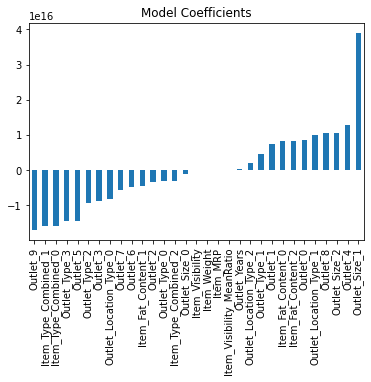

In [50]:
predictors = [col for col in train.columns if col not in [target]+IDcol]
algo1 = LinearRegression(normalize = True)
modelfit(algo1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(algo1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Reporte de Modelo
RMSE: 1129
CV Score: Mean - 1130 | Std - 45 | Min - 1076 | Max - 1217


<AxesSubplot:title={'center':'Model Coefficients'}>

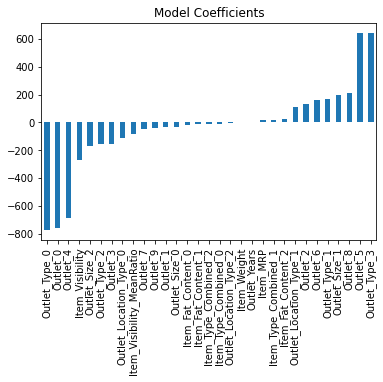

In [51]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')


Reporte de Modelo
RMSE: 1058
CV Score: Mean - 1091 | Std - 45 | Min - 1003 | Max - 1186


<AxesSubplot:title={'center':'Feature Importances'}>

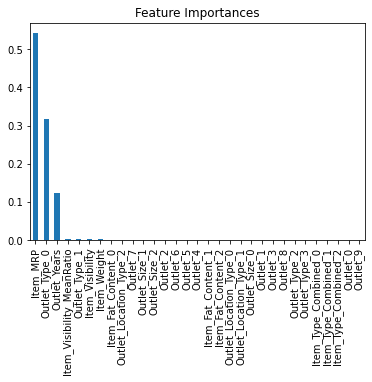

In [52]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')


Reporte de Modelo
RMSE: 1071
CV Score: Mean - 1096 | Std - 43 | Min - 1027 | Max - 1172


<AxesSubplot:title={'center':'Feature Importances'}>

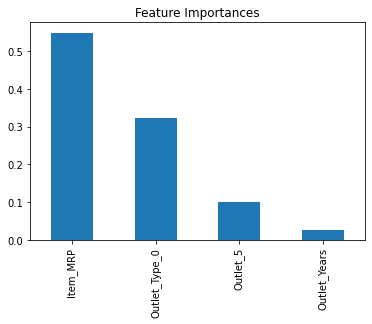

In [53]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')


Reporte de Modelo
RMSE: 1073
CV Score: Mean - 1084 | Std - 44 | Min - 1019 | Max - 1163


<AxesSubplot:title={'center':'Feature Importances'}>

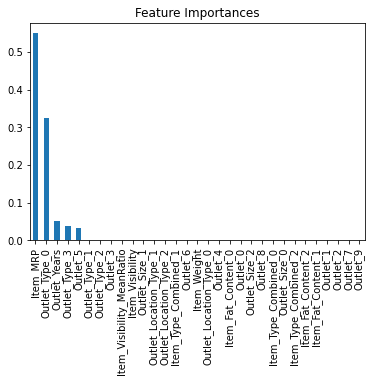

In [54]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')


Reporte de Modelo
RMSE: 1068
CV Score: Mean - 1083 | Std - 44 | Min - 1019 | Max - 1161


<AxesSubplot:title={'center':'Feature Importances'}>

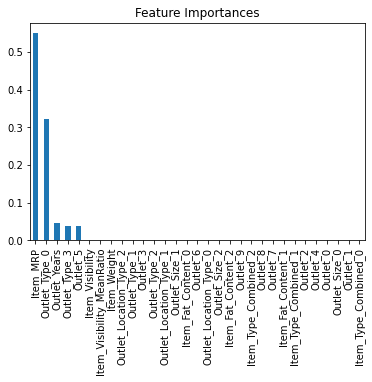

In [55]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')